In [2]:
import pandas as pd
import numpy as np
import os
import re
import random
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.io as pio
import glob
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
from datetime import datetime

from dateutil.relativedelta import relativedelta


In [3]:
def read_lmp_hourly(folder_path):
    """
    Reads all CSV files in the specified folder and combines them into a single DataFrame.
    
    Parameters:
    folder_path (str): Path to the folder containing the CSV files.
    
    Returns:
    pandas.DataFrame: Combined DataFrame of all CSV files.
    """
    # Use glob to find all CSV files in the folder
    csv_files = glob.glob(folder_path + '*.csv')
    
    # Read each CSV file and concatenate them into a single DataFrame
    df_list = [pd.read_csv(file) for file in csv_files]
    combined_df = pd.concat(df_list, ignore_index=True)
    combined_df['date'] = pd.to_datetime(combined_df['DeliveryDate'].apply(str)).dt.to_period('D').dt.to_timestamp()
    combined_df['month'] = combined_df['date'].dt.to_period('M').dt.to_timestamp()
    
    def extract_hour(time_str): # extract hour for dam price , LMPhourly
        return int(time_str.split(':')[0])
    combined_df['hour'] = combined_df['HourEnding'].apply(extract_hour)
    
    return combined_df

In [4]:
top_df = pd.read_csv("tree_method_top.csv") #most traded 
tail_df = pd.read_csv("tree_method_tail.csv") #least traded
LMP_hourly = read_lmp_hourly("Dayahead_Price/")
# top_df = top_df[top_df['ShadowPricePerMWH']>0]

In [5]:
top_df.head()

,Source,Sink,TimeOfUse,StartDate,EndDate,ShadowPricePerMWH,date,duration,auction_info,score,auction_date,agg_MW,CRRPerMWH
0,CBECII_89,HB_HOUSTON,Off-peak,01/01/2024,03/31/2024,1.024268,2024-01-01,3,2024.1st6.AnnualAuction.Seq2,0.070303,2023-05-16,12528.0,0.143732
1,CBECII_89,HB_HOUSTON,Off-peak,01/01/2024,03/31/2024,1.742868,2024-01-01,3,2024.1st6.AnnualAuction.Seq3,0.070303,2022-12-13,8769.6,0.143732
2,CBECII_89,HB_HOUSTON,Off-peak,01/01/2024,03/31/2024,2.030000,2024-01-01,3,2024.1st6.AnnualAuction.Seq4,0.070303,2022-07-19,6264.0,0.143732
3,CBECII_89,HB_HOUSTON,Off-peak,04/01/2024,06/30/2024,1.029079,2024-04-01,3,2024.1st6.AnnualAuction.Seq2,0.069257,2023-05-16,6348.0,-0.367913
4,CBECII_89,HB_HOUSTON,Off-peak,04/01/2024,06/30/2024,2.220000,2024-04-01,3,2024.1st6.AnnualAuction.Seq4,0.069257,2022-07-19,8887.2,-0.367913


<Axes: >

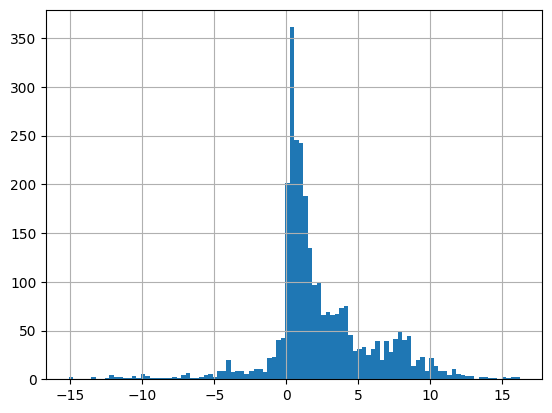

In [5]:
top_df.ShadowPricePerMWH.hist(bins=100)

In [6]:
# top_df = top_df[top_df['ShadowPricePerMWH']>0]

In [6]:
top_df

,Source,Sink,TimeOfUse,StartDate,EndDate,ShadowPricePerMWH,date,duration,auction_info,score,auction_date,agg_MW,CRRPerMWH
0,CBECII_89,HB_HOUSTON,Off-peak,01/01/2024,03/31/2024,1.024268,2024-01-01,3,2024.1st6.AnnualAuction.Seq2,0.070303,2023-05-16,12528.0,0.143732
1,CBECII_89,HB_HOUSTON,Off-peak,01/01/2024,03/31/2024,1.742868,2024-01-01,3,2024.1st6.AnnualAuction.Seq3,0.070303,2022-12-13,8769.6,0.143732
2,CBECII_89,HB_HOUSTON,Off-peak,01/01/2024,03/31/2024,2.030000,2024-01-01,3,2024.1st6.AnnualAuction.Seq4,0.070303,2022-07-19,6264.0,0.143732
3,CBECII_89,HB_HOUSTON,Off-peak,04/01/2024,06/30/2024,1.029079,2024-04-01,3,2024.1st6.AnnualAuction.Seq2,0.069257,2023-05-16,6348.0,-0.367913
4,CBECII_89,HB_HOUSTON,Off-peak,04/01/2024,06/30/2024,2.220000,2024-04-01,3,2024.1st6.AnnualAuction.Seq4,0.069257,2022-07-19,8887.2,-0.367913
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2929,WILDWIND_ALL,HB_NORTH,PeakWD,01/01/2024,06/30/2024,1.604288,2024-01-01,6,2024.1st6.AnnualAuction.Seq4,0.051932,2022-07-19,663.6,0.163624
2930,WILDWIND_ALL,HB_NORTH,PeakWE,01/01/2024,06/30/2024,0.431107,2024-01-01,6,2024.1st6.AnnualAuction.Seq1,0.056962,2023-10-17,6918.0,0.024664
2931,WILDWIND_ALL,HB_NORTH,PeakWE,01/01/2024,06/30/2024,0.503060,2024-01-01,6,2024.1st6.AnnualAuction.Seq2,0.056962,2023-05-16,18678.6,0.024664
2932,WILDWIND_ALL,HB_NORTH,PeakWE,01/01/2024,06/30/2024,0.516174,2024-01-01,6,2024.1st6.AnnualAuction.Seq3,0.056962,2022-12-13,9685.2,0.024664


In [10]:
top_df[(top_df.Source == 'CBECII_89')&(top_df.Sink == 'HB_HOUSTON')]

,Source,Sink,TimeOfUse,StartDate,EndDate,ShadowPricePerMWH,date,duration,auction_info,score,auction_date,agg_MW,CRRPerMWH
0,CBECII_89,HB_HOUSTON,Off-peak,01/01/2024,03/31/2024,1.024268,2024-01-01,3,2024.1st6.AnnualAuction.Seq2,0.070303,2023-05-16,12528.0,0.143732
1,CBECII_89,HB_HOUSTON,Off-peak,01/01/2024,03/31/2024,1.742868,2024-01-01,3,2024.1st6.AnnualAuction.Seq3,0.070303,2022-12-13,8769.6,0.143732
2,CBECII_89,HB_HOUSTON,Off-peak,01/01/2024,03/31/2024,2.030000,2024-01-01,3,2024.1st6.AnnualAuction.Seq4,0.070303,2022-07-19,6264.0,0.143732
3,CBECII_89,HB_HOUSTON,Off-peak,04/01/2024,06/30/2024,1.029079,2024-04-01,3,2024.1st6.AnnualAuction.Seq2,0.069257,2023-05-16,6348.0,-0.367913
4,CBECII_89,HB_HOUSTON,Off-peak,04/01/2024,06/30/2024,2.220000,2024-04-01,3,2024.1st6.AnnualAuction.Seq4,0.069257,2022-07-19,8887.2,-0.367913
5,CBECII_89,HB_HOUSTON,Off-peak,04/01/2024,06/30/2024,2.620000,2024-04-01,3,2024.1st6.AnnualAuction.Seq3,0.069257,2022-12-13,8887.2,-0.367913
6,CBECII_89,HB_HOUSTON,PeakWD,01/01/2024,03/31/2024,2.730000,2024-01-01,3,2024.1st6.AnnualAuction.Seq5,0.077718,2022-02-15,2665.2,0.420839
7,CBECII_89,HB_HOUSTON,PeakWD,01/01/2024,03/31/2024,3.848217,2024-01-01,3,2024.1st6.AnnualAuction.Seq4,0.077718,2022-07-19,3997.8,0.420839
8,CBECII_89,HB_HOUSTON,PeakWD,01/01/2024,03/31/2024,4.626262,2024-01-01,3,2024.1st6.AnnualAuction.Seq2,0.077718,2023-05-16,13326.0,0.420839
9,CBECII_89,HB_HOUSTON,PeakWD,01/01/2024,03/31/2024,5.200000,2024-01-01,3,2024.1st6.AnnualAuction.Seq3,0.077718,2022-12-13,21321.6,0.420839


In [32]:
top_df['StartDate'] = pd.to_datetime(top_df['StartDate'])
top_df['EndDate'] = pd.to_datetime(top_df['EndDate'])
top_df['auction_date'] = pd.to_datetime(top_df['auction_date'])
tail_df['StartDate'] = pd.to_datetime(tail_df['StartDate'])
tail_df['EndDate'] = pd.to_datetime(tail_df['EndDate'])
tail_df['auction_date'] = pd.to_datetime(tail_df['auction_date'])

In [33]:
LMP_hourly = LMP_hourly.sort_values(by = ['date', 'hour'], ascending = True)

LMP_hourly

,DeliveryDate,HourEnding,SettlementPoint,SettlementPointPrice,DSTFlag,date,month,hour
10057639,01/02/2021,01:00,AEEC,22.00,N,2021-01-02,2021-01-01,1
10057640,01/02/2021,01:00,ALVIN_RN,22.08,N,2021-01-02,2021-01-01,1
10057641,01/02/2021,01:00,AMADEUS_ALL,22.01,N,2021-01-02,2021-01-01,1
10057642,01/02/2021,01:00,AMISTAD_ALL,22.57,N,2021-01-02,2021-01-01,1
10057643,01/02/2021,01:00,AMOCOOIL_CC1,22.08,N,2021-01-02,2021-01-01,1
...,...,...,...,...,...,...,...,...
16018108,10/31/2024,24:00,W_HRL_ESR_RN,23.30,N,2024-10-31,2024-10-01,24
16018109,10/31/2024,24:00,W_PECO_UNIT1,94.61,N,2024-10-31,2024-10-01,24
16018110,10/31/2024,24:00,X443ESRN,24.20,N,2024-10-31,2024-10-01,24
16018111,10/31/2024,24:00,YNG_WND_ALL,12.29,N,2024-10-31,2024-10-01,24


In [34]:
top_df['dist_days'] = (top_df['StartDate'] - top_df['auction_date']).dt.days
top_df['predict_result'] = top_df['CRRPerMWH'] - top_df['ShadowPricePerMWH']
tail_df['dist_days'] = (tail_df['StartDate'] - tail_df['auction_date']).dt.days
tail_df['predict_result'] = tail_df['CRRPerMWH'] - tail_df['ShadowPricePerMWH']

In [35]:
top_df['tree_y'] = [1 if x > 0 else 0 for x in top_df['predict_result']]
tail_df['tree_y'] = [1 if x > 0 else 0 for x in tail_df['predict_result']]

In [36]:
top_df['auction_date'] = pd.to_datetime(top_df['auction_date'])
tail_df['auction_date'] = pd.to_datetime(tail_df['auction_date'])

In [37]:
LMP_hourly['date'] = pd.to_datetime(LMP_hourly['date'])  # Convert 'date' to datetime
LMP_hourly['hour'] = LMP_hourly['hour'].astype(int)      # Ensure 'hour' is integer

    # Add a datetime column for filtering
LMP_hourly['datetime'] = LMP_hourly['date'] + pd.to_timedelta(LMP_hourly['hour'], unit='h')

In [38]:
# from tqdm import tqdm

# data_df = []

# for idx,row in tqdm(top_df.iterrows()):
#     auction_date = row['auction_date']
#     source = row['Source']  # Assumes column name 'Source' for SettlementPoint
#     sink = row['Sink']      # Assumes column name 'Sink' for SettlementPoint

#     start_time = auction_date - pd.Timedelta(days=2)  # Start 2 days before the auction date
#     end_time = auction_date + pd.Timedelta(hours=17)  # End at 5:00 PM on the auction date

#     source_data = LMP_hourly[
#         (LMP_hourly['datetime'] >= start_time) &
#         (LMP_hourly['datetime'] < end_time) &
#         (LMP_hourly['SettlementPoint'] == source)
#     ].copy()  # Use .copy() to avoid SettingWithCopyWarning

#     sink_data = LMP_hourly[
#         (LMP_hourly['datetime'] >= start_time) &
#         (LMP_hourly['datetime'] < end_time) &
#         (LMP_hourly['SettlementPoint'] == sink)
#     ].copy()
#     #print(sink_data)
#     # Calculate lagged column names for source and sink
#     source_data['col'] = source_data.apply(
#         lambda r: f"source_lag_{int(((auction_date + pd.Timedelta(hours=17)) - r['datetime']).total_seconds() / 3600)}",
#         axis=1
#     )

#     sink_data['col'] = sink_data.apply(
#         lambda r: f"sink_lag_{int(((auction_date + pd.Timedelta(hours=17)) - r['datetime']).total_seconds() / 3600)}",
#         axis=1
#     )

#     # Prepare dataframes for pivoting
#     source_data = source_data[['col', 'SettlementPointPrice']].set_index('col').T
#     sink_data = sink_data[['col', 'SettlementPointPrice']].set_index('col').T

#     # Merge source and sink data
#     lookback_data = pd.concat([sink_data, source_data], axis=1)

#     data_df.append(lookback_data)

#     # if idx > 10:
#     #     break

# data_df = pd.concat(data_df)

# data_df.to_csv("data_df.csv")

data_df = pd.read_csv("data_df.csv",index_col=0)

In [39]:
data_df_clean = data_df.reset_index(drop=True)
top_df_copy = top_df.reset_index(drop=True).copy()

top_df_copy = pd.concat([top_df, data_df_clean], axis=1)

In [40]:
top_df_copy.columns

Index(['Source', 'Sink', 'TimeOfUse', 'StartDate', 'EndDate',
       'ShadowPricePerMWH', 'date', 'duration', 'auction_info', 'score',
       ...
       'source_lag_10', 'source_lag_9', 'source_lag_8', 'source_lag_7',
       'source_lag_6', 'source_lag_5', 'source_lag_4', 'source_lag_3',
       'source_lag_2', 'source_lag_1'],
      dtype='object', length=146)

In [ ]:
top_df_copy.durations

In [41]:
# examine correlation between variables
vars = top_df_copy.drop(columns = ['ShadowPricePerMWH', 'StartDate', 'EndDate', 'date', 'auction_info', 'auction_date', 'agg_MW', 'CRRPerMWH', 'predict_result', 'Sink', 'Source', 'TimeOfUse'])
print(vars.columns)

vars_corr = vars.corr(method='pearson')
mask = np.triu(np.ones_like(vars_corr, dtype=bool))
vars_corr = vars_corr.mask(mask)

fig = px.imshow(vars_corr, text_auto = True, color_continuous_scale="Tropic")
fig.update_layout(
    title=f'Correlation heatmap for my data',
    width=1000, height=1000,
    title_font=dict(size=16, color='black'),  # Customize title font
    title_x=0.5  # Center the title
)
fig.show()

Index(['duration', 'score', 'dist_days', 'tree_y', 'sink_lag_65',
       'sink_lag_64', 'sink_lag_63', 'sink_lag_62', 'sink_lag_61',
       'sink_lag_60',
       ...
       'source_lag_10', 'source_lag_9', 'source_lag_8', 'source_lag_7',
       'source_lag_6', 'source_lag_5', 'source_lag_4', 'source_lag_3',
       'source_lag_2', 'source_lag_1'],
      dtype='object', length=134)


In [28]:
# Step 1: Split the data into training, validation, and testing
test_df = top_df_copy[top_df_copy['auction_date'] > '2023-04-30'].drop(columns = ['ShadowPricePerMWH','StartDate', 'EndDate', 'date', 'auction_info', 'auction_date', 'agg_MW', 'CRRPerMWH', 'predict_result']).dropna()
valid_df = top_df_copy[(top_df_copy['auction_date'] <= '2023-04-30')&(top_df_copy['auction_date'] > '2022-11-30')].drop(columns = ['ShadowPricePerMWH', 'StartDate', 'EndDate', 'date', 'auction_info', 'auction_date', 'agg_MW', 'CRRPerMWH', 'predict_result']).dropna()
train_df = top_df_copy[(top_df_copy['auction_date'] <= '2022-11-30')].drop(columns = ['ShadowPricePerMWH','StartDate', 'EndDate', 'date', 'auction_info', 'auction_date', 'agg_MW', 'CRRPerMWH', 'predict_result']).dropna()

test_df.columns[:30]

Index(['Source', 'Sink', 'TimeOfUse', 'duration', 'score', 'dist_days',
       'tree_y', 'sink_lag_65', 'sink_lag_64', 'sink_lag_63', 'sink_lag_62',
       'sink_lag_61', 'sink_lag_60', 'sink_lag_59', 'sink_lag_58',
       'sink_lag_57', 'sink_lag_56', 'sink_lag_55', 'sink_lag_54',
       'sink_lag_53', 'sink_lag_52', 'sink_lag_51', 'sink_lag_50',
       'sink_lag_49', 'sink_lag_48', 'sink_lag_47', 'sink_lag_46',
       'sink_lag_45', 'sink_lag_44', 'sink_lag_43'],
      dtype='object')

In [42]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import itertools


y_test = test_df['tree_y']
y_val = valid_df['tree_y']
y_train = train_df['tree_y']

X_test= test_df.drop(columns = [ 'tree_y'])
X_val = valid_df.drop(columns = ['tree_y'])
X_train = train_df.drop(columns = ['tree_y'])


categorical_columns = X_test.select_dtypes(include=['object']).columns
for col in categorical_columns:
    X_test[col] = X_test[col].astype('category')
    X_val[col] = X_val[col].astype('category')
    X_train[col] = X_train[col].astype('category')


# Step 3: Define the parameter grid
param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.1, 0.2],
    'max_depth': [3, 5],
    'subsample': [0.8, 1],
    'colsample_bytree': [0.8, 1]
}

# Step 4: Manual grid search
best_model = None
best_params = None
highest_val_accuracy = 0

# Iterate over all combinations of parameters
for params in itertools.product(*param_grid.values()):
    params_dict = dict(zip(param_grid.keys(), params))
    
    # Initialize XGBoost model with categorical support
    model = xgb.XGBClassifier(
        objective='binary:logistic',  # For binary classification
        enable_categorical=True,
        random_state=42,
        **params_dict
    )
    # Train on the training set
    model.fit(X_train, y_train)
    
    # Predict on the validation set
    y_val_pred = model.predict(X_val)
    val_accuracy = accuracy_score(y_val, y_val_pred)
    
    # Update best model if validation accuracy is higher
    if val_accuracy > highest_val_accuracy:
        best_model = model
        best_params = params_dict
        highest_val_accuracy = val_accuracy

print("Best Parameters:", best_params)
print(f"Best Validation Accuracy: {highest_val_accuracy}")

# Step 5: Evaluate the best model on the test set
y_test_pred = best_model.predict(X_test)

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_test_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Additional Metrics
test_accuracy = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred)
test_recall = recall_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred)

print(f"Test Accuracy: {test_accuracy}")
print(f"Test Precision: {test_precision}")
print(f"Test Recall: {test_recall}")
print(f"Test F1 Score: {test_f1}")

Best Parameters: {'n_estimators': 200, 'learning_rate': 0.1, 'max_depth': 5, 'subsample': 1, 'colsample_bytree': 1}
Best Validation Accuracy: 0.8170103092783505
Confusion Matrix:
[[286  14]
 [ 94  42]]
Test Accuracy: 0.7522935779816514
Test Precision: 0.75
Test Recall: 0.3088235294117647
Test F1 Score: 0.4375


In [43]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

categorical_cols = ['Source', 'Sink', 'TimeOfUse']

# Apply One-Hot Encoding to small-cardinality categorical columns
auction_top_df = pd.get_dummies(top_df, columns=categorical_cols, drop_first=True)

test_df = auction_top_df[auction_top_df['auction_date'] > '2023-04-30'].drop(columns = ['StartDate', 'EndDate', 'date', 'auction_info', 'auction_date', 'agg_MW', 'predict_result']).dropna()
valid_df = auction_top_df[(auction_top_df['auction_date'] <= '2023-04-30')&(auction_top_df['auction_date'] > '2022-11-30')].drop(columns = [ 'StartDate', 'EndDate', 'date', 'auction_info', 'auction_date', 'agg_MW',  'predict_result']).dropna()
train_df = auction_top_df[(auction_top_df['auction_date'] <= '2022-11-30')].drop(columns = ['StartDate', 'EndDate', 'date', 'auction_info', 'auction_date', 'agg_MW', 'predict_result']).dropna()

X_test= test_df.drop(columns = [ 'tree_y','ShadowPricePerMWH','CRRPerMWH'])
X_val = valid_df.drop(columns = ['tree_y','ShadowPricePerMWH','CRRPerMWH'])
X_train = train_df.drop(columns = ['tree_y','ShadowPricePerMWH','CRRPerMWH'])

# Display the transformed DataFrame
y_test_auction = test_df['ShadowPricePerMWH']
y_val_auction = valid_df['ShadowPricePerMWH']
y_train_auction = train_df['ShadowPricePerMWH']

y_test_CRR = test_df['CRRPerMWH']
y_val_CRR = valid_df['CRRPerMWH']
y_train_CRR = train_df['CRRPerMWH']

In [44]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
random.seed(42)
# Scaling numerical features
scaler = StandardScaler()

# Scale training, validation, and test sets
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Neural Network Model
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),  # Input layer with 64 neurons
    Dropout(0.2),  # Dropout layer to prevent overfitting
    Dense(32, activation='relu'),  # Hidden layer with 32 neurons
    Dropout(0.2),
    Dense(1)  # Output layer for regression
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error'])

# Train the model
history = model.fit(
    X_train_scaled, y_train_auction,
    validation_data=(X_val_scaled, y_val_auction),
    epochs=50,
    batch_size=32,
    verbose=1
)

# Evaluate the model on the test set
test_loss, test_mae = model.evaluate(X_test_scaled, y_test_auction, verbose=0)
y_test_auction_pred = model.predict(X_test_scaled, verbose = 0)
# Print evaluation metrics
print(f"Test Loss (MSE): {test_loss}, Test MAE: {test_mae}")


/Users/leroy/Documents/GitHub/Electricity_trading/venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Epoch 1/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 15.5944 - mean_absolute_error: 2.7581 - val_loss: 9.8130 - val_mean_absolute_error: 2.0800
Epoch 2/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 11.0612 - mean_absolute_error: 2.1281 - val_loss: 5.4147 - val_mean_absolute_error: 1.5689
Epoch 3/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 6.2721 - mean_absolute_error: 1.5911 - val_loss: 4.4405 - val_mean_absolute_error: 1.4417
Epoch 4/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.9956 - mean_absolute_error: 1.4954 - val_loss: 4.4833 - val_mean_absolute_error: 1.5063
Epoch 5/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.5311 - mean_absolute_error: 1.4615 - val_loss: 4.7243 - val_mean_absolute_error: 1.5346
Epoch 6/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.1801 - mean_absolute_error: 1.3766 - val_loss: 5.0920 - val_mean_absolute_error: 1.5742
Epoch 7/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.1812 - mean_absolute_error: 1.3782 - val_loss: 4.

In [45]:
import plotly.graph_objects as go

# Extract loss values from training history (Ensure history exists)
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Create a Plotly figure
fig = go.Figure()

# Add training loss trace
fig.add_trace(go.Scatter(
    y=train_loss,
    mode='lines',
    name='Training Loss',
    line=dict(width=2)
))

# Add validation loss trace
fig.add_trace(go.Scatter(
    y=val_loss,
    mode='lines',
    name='Validation Loss',
    line=dict(width=2, dash='dash')
))

# Customize layout
fig.update_layout(
    title='Loss Change Over Epochs',
    xaxis_title='Epochs',
    yaxis_title='Loss (MSE)',
    legend=dict(font=dict(size=12)),
    template='plotly_white'
)

# Show the figure
fig.show()

In [46]:
profit = 0
success = 0
y_test_auction = y_test_auction.reset_index(drop = True)
y_test_CRR = y_test_CRR.reset_index(drop = True)
for i in range(len(y_test_pred)):
    if y_test_pred[i] == 1:
        if y_test_auction_pred[i][0] >= y_test_auction[i]:
            success += 1
            profit +=  max(0,y_test_CRR[i] - y_test_auction[i])

profit

4.152514895287613

In [47]:
n_trails = 10000
larger_cnt = 0
for i in range(n_trails):
    # Initialize an array of 610 elements, all set to 0
    profit_compare = 0
    random_compare = np.zeros(510, dtype=int)

    # Randomly select 212 unique indices from the array
    random_indices = np.random.choice(len(random_compare), 56, replace=False)
    random_compare[random_indices] = 1
    profit_compare = 0
    for i in range(len(random_compare)):
        if random_compare[i] == 1:
            if y_test_auction_pred[i][0] >= y_test_auction[i]:
                profit_compare += max(0, y_test_CRR[i] - y_test_auction[i])

    if profit_compare >= profit:
        larger_cnt += 1
        
larger_cnt/n_trails

0.9959

In [48]:
pnl = 0
y_test_auction = y_test_auction.reset_index(drop = True)
y_test_CRR = y_test_CRR.reset_index(drop = True)
for i in range(len(y_test_pred)):
    if y_test_pred[i] == 1:
        if y_test_auction_pred[i][0] >= y_test_auction[i]:
            pnl +=  max(0,y_test_CRR[i] - y_test_auction[i]) - y_test_auction[i]

pnl

-4.1358551047123875

In [49]:
n_trails = 10000
larger_cnt = 0
for i in range(n_trails):
    # Initialize an array of 610 elements, all set to 0
    pnl_compare = 0
    random_compare = np.zeros(510, dtype=int)

    # Randomly select 212 unique indices from the array
    random_indices = np.random.choice(len(random_compare), 56, replace=False)
    random_compare[random_indices] = 1
    profit_compare = 0
    for i in range(len(random_compare)):
        if random_compare[i] == 1:
            if y_test_auction_pred[i][0] >= y_test_auction[i]:
                pnl_compare += max(0, y_test_CRR[i] - y_test_auction[i]) - y_test_auction[i]

    if pnl_compare >= pnl:
        larger_cnt += 1
        
larger_cnt/n_trails

0.5719